<h1><center><font size="6">Kredi Kartı Dolandırıcılık Tespiti - Random Forest</font></center></h1>

# Giriş 

Bu çalışmada kullandığımız veriseti Eylül 2013'te iki gün içerisinde yapılan para transferlerinin bilgilerini bulunduruyor. Veri setindeki 284.807 transferden 492 adedi dolandırıcılık faaliyeti olarak sınıflandırılıyor. Bu sayılardan da anlayabileceğiniz gibi hayli dengesiz bir veriseti söz konusu. Pozitif (dolandırıcılık olan) faaliyetlerin verisetindeki tüm faaliyetlere oranı %0,172.

Temel bileşenler analizi uygulayabilmek adına verisetindeki tüm girdiler yalnızca sayısal değerlere dönüştürülmüştür. 

   *Temel Bileşenler Analizi(PCA):*   Temel bileşenler analizinde girdi olarak kullanılan verilere bir ön işleme uygulanarak verilerin boyutları düşürülür. Veriler doğrusal olarak yeni bir koordinat düzlemine dönüştürülür. Bu sayede verilerdeki en kritik değişimleri yakalayan temel bileşenler tespit edilmiş olur. Daha az veriyle anlamlı sonuçlar elde ederiz. 


# Paketlerin Yüklenmesi

In [69]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
import lightgbm as LGBMModel
from lightgbm import LGBMClassifier
import xgboost as xgb
import os
import time

pd.set_option('display.max_columns', 100)

RANDOM_STATE = 2018
MAX_ROUNDS = 1000 #En fazla iterasyon sayisi


# Verisetini Okuyalım

In [70]:
data_df = pd.read_csv("../input/creditcardfraud/creditcard.csv")
print("Satirlar:",data_df.shape[0]," Sutunlar:", data_df.shape[1])

Satirlar: 284807  Sutunlar: 31


In [71]:
class_0 = data_df[data_df['Class'] == 0]
class_1 = data_df[data_df['Class'] == 1]

sample_0 = class_0.sample(n=80000, random_state=1)
sample_1 = class_1.sample(n=490, random_state=1)

# Örnekleri birleştirme
sampled_data = pd.concat([sample_0, sample_1])

# Veriyi karıştırma
shuffled_data = sampled_data.sample(frac=1, random_state=1).reset_index(drop=True)
data_df = shuffled_data 

## Verisetine Bir Bakış

İlk beş satırı inceleyelim.

In [72]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,165496.0,0.096248,0.811113,-0.006953,-0.743035,0.689782,-0.743619,0.956785,-0.129756,0.092556,-0.392045,-1.645510,-0.404742,-0.459949,0.188212,-0.288126,0.135894,-0.626039,-0.450944,0.180725,-0.057009,-0.313561,-0.746755,-0.011388,-0.677702,-0.417537,0.183151,0.242836,0.089008,2.28,0
1,91785.0,2.144360,-0.484035,-1.511321,-1.271689,-0.020378,-0.887141,-0.117293,-0.389268,3.320349,-1.340794,-0.525294,-1.790910,1.788160,1.464278,-0.563580,-1.101548,0.656011,0.084516,1.006691,-0.238723,-0.097578,0.388584,-0.083354,-0.752689,0.365667,-0.042692,-0.027641,-0.077451,7.57,0
2,37299.0,1.375577,-0.419460,0.615182,-0.792305,-1.005278,-0.715165,-0.616627,-0.081245,-1.123556,0.764632,1.618157,0.461397,0.685649,-0.075104,0.048618,1.404191,-0.067129,-1.158523,0.896277,0.104714,-0.040521,-0.232404,0.120452,0.318543,0.221826,-0.499698,0.011354,0.012671,2.95,0
3,160981.0,-0.639570,-0.234346,1.403517,1.055268,1.460704,0.380254,0.330439,-0.164897,0.440367,0.318589,-0.163834,0.592144,-0.282636,-0.532970,-1.501856,-0.718945,-0.388821,0.022584,1.745108,0.168567,-0.465846,-0.892413,0.094685,-0.871738,-0.788101,-1.045324,-0.262034,-0.090915,15.40,0
4,70789.0,-0.475682,1.171995,1.254787,0.051053,0.024513,-0.986357,0.701840,-0.110416,-0.326226,-0.401086,-0.202715,-0.078684,0.122225,-0.465224,0.902353,0.370416,0.001482,-0.146113,-0.087285,0.098656,-0.246416,-0.689226,0.004352,0.333412,-0.169005,0.059377,0.109928,0.097755,4.49,0


# Tahmin Modelleri

Tahminleyicileri ve hedef değerleri tanımlayalım 

In [73]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

Eğitim setini, test setini ve doğrulama setini ayıralım 

In [74]:
train_df, test_df = train_test_split(data_df, test_size=0.20, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=RANDOM_STATE, shuffle=True )

## Random Forest Sınıflandırıcı
Random Forest sınıflandırmanın temelinde rasgelelik vardır. Rasgele seçtiğimiz datalar ve değişkenlerle bir çok ağaç oluştururuz ve bu ağaçların en iyi çalışanlarıyla Random Ormanımızı oluşturmuş oluyoruz. Örneğin 100 tane örnek ve 20 değişkene sahip bir veri setinde bu yöntem uygulanmak istenildiğinde, 100 örnek içerisinden 20 tane örneği, 20 değişkenden de 4er değişkeni rastgele seçer ve bu değişkenler üzerinden karar ağaçları oluşturulur. Bu ağaçların verdiği kararlar bir oylama gibi toplanıp kıyaslanır ve çoğunlukta olan oya karar verilir.
### Avantajları
Aşırı öğrenmenin önüne geçen bir yöntemdir. <br>
Gürültüleri, outlierları ve eksik bilgileri tolere eder. <br>
Yüksek doğrulukta çalışır. <br>

### Dezavantajları
Karmaşıktır. <br>
Memory kullanımı yüksek olabilir. <br>
Diğer algoritmalara kıyasla daha uzun sürede tahminde bulunabilir.<br>


<img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEiN2KPoea9rFZo4nb0SZKrBrEUjNv-xaqB7gF6Htl5lY5AtOmKH1yFalD9Y6XHNNgtUYqsJCPUr-7a4MJIvdcubXogxerrskVqKfQGhKSpUyrnroLhEi6P5vMXqYE22J3_dnLRuWiBv5Nw/s0/Random+Forest+03.gif" width="600"/>


Programın çalışmasının ne kadar süreceğini anlamak için ufak bir kod yazalım:

In [75]:
start_time = time.time()

Eğitim setiyle modeli eğittikten sonra doğrulama setiyle doğruluğunu ölçelim.

    Tahminleyici sayısı = 100 
    Paralel iş sayısı = 4

RandomForestClassifier'ı tanımlayarak başlayalım.

In [76]:
clf = RandomForestClassifier(n_jobs=4, #Ayni anda farkli islem birimlerinde calisacak islerin sayisi
                             #random_state=RANDOM_STATE,  #Agaclara dagitilan feature ve orneklerin rasgeleliklerini kontrol eder
                                                         #Default hali none
                             criterion='gini', #Gini Safsizligi, 0 ile 0.5 araliginda degerler alir. 
                             # 0, homojen(tek sinif) veri setini, 0.5 ise tamamen heterojen(esit dagilimda kumeler) 
                             # veri setini ifade eder.
                             n_estimators=100, # Kac adet oy verecek agac olacagini tuttugumuz parametre
                             verbose=2) #Bu parametreye integer degerler verirsek model 
                             # olusturulurken model hakkinda bilgi verir. False yazarsak hicbir bilgi vermez.
                             # 1 -> temel bilgi, 2-> daha ayrintili bilgiler

"train_df" verisini ve "fit" fonksiyonunu kullanarak modeli eğitmeye başlayalım.

In [77]:
clf.fit(train_df[predictors], train_df[target].values)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 28 of 100building tree 27 of 100

building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.7s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   17.9s finished


RandomForestClassifier(n_jobs=4, verbose=2)

"valid_df" verisini ve "predict" fonksiyonunu kullanarak doğruluğunu ölçelim.

In [78]:
preds = clf.predict(valid_df[predictors])
end_time = time.time()
elapsed_time = end_time - start_time

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Feature'ların önemlerini görselleştirelim.

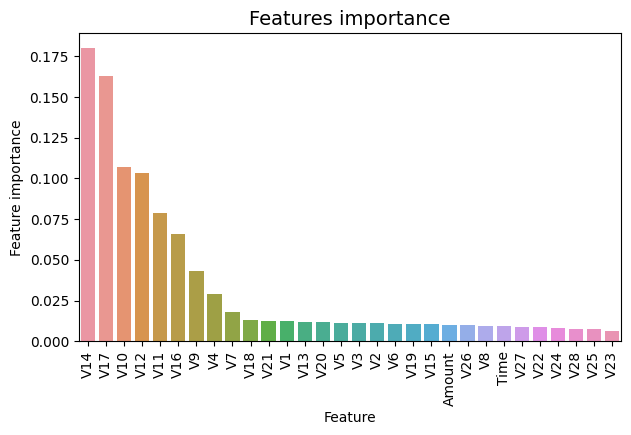

In [79]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


En önemli featurelar **V17**, **V12**, **V14**, **V10**, **V11**, **V16**.


### Karmaşıklık Matrisi

Bulduğumuz sonuçlarla karmaşıklık matrisini çizelim. 

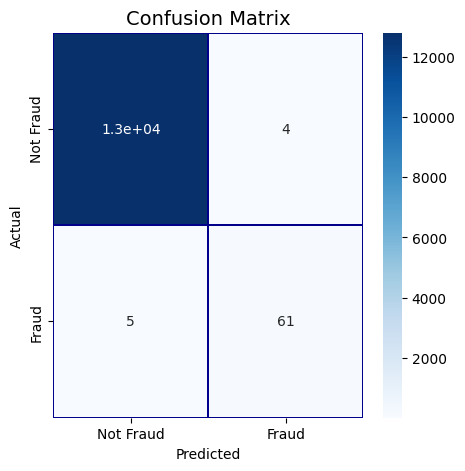

In [80]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

### Tip I ve Tip II hatalar

Karmaşıklık matrisleri dengesiz verisetlerini temsil etmekte çok iyi bir araç değiller. Seçicilik ve özgüllük parametrelerini ölçen daha farklı araçlara ihtiyaç duyarız, böylece Tip I ve Tip II hataları minimize ederiz


**Null Hipotezi** (**H0**) - Transfer dolandırıcılık faaliyeti içermez. 
**Alternatif Hipotez** (**H1**) - Transfer dolandırıcılık faaliyetidir.

**Tip I Hata** -Null Hipotezi doğru olduğu halde reddettiğimiz durumlara denir.
**Tip II Hata** - Alternatif Hipotez doğru olduğu halde Null Hipotezi kabul ettiğimiz durumlara denir.

**Tip I Hatanın Maaliyeti** - İşlemin bir dolandırıcılık olduğu varsayımıyla hatalı bir şekilde işlem reddedilir. 
**Tip II Hatanın Maaliyeti** - İşlemin bir dolandırıcılık olmadığı varsayımıyla hatalı bir şekilde işlem kabul edilir. 

<img src="https://i2.wp.com/flowingdata.com/wp-content/uploads/2014/05/Type-I-and-II-errors1.jpg" width="600"/>


ROC-AUC skorunu hesaplayalım.
#### ROC(Receiver Operating Characteristic) ve AUC(Area Under Curve)
ROC eğrisi sınıflandırma problemleri için çok önemli bir performans ölçümüdür. 
ROC bir olasılık eğrisidir ve altında kalan alan olan AUC ayrılabilirliğin derecesini veya ölçüsünü temsil eder.
ROC eğrisinde X ekseninde FPR(Yanlış Pozitif Oran) ve Y ekseninde ise TPR (Gerçek Pozitif Oranı) bulunmaktadır. AUC ne kadar yüksekse, model doğru tahminlerde o kadar başarılıdır denebilir.

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*Lqkajn8HR2jybYNkKsO6Sg.png" width="600"/>


In [81]:
roc_auc_score(valid_df[target].values, preds)

0.9619651206516111

In [82]:
f1_score(valid_df[target].values, preds, average=None)

array([0.99964881, 0.93129771])

In [83]:
print(f" {elapsed_time:.4f} saniye")

 18.1274 saniye


## Parametrelerin Değişimine Göre Kodun Performansı

### Paralel İşler
Aynı anda farklı işlem birimlerinde çalışacak kod sayısını belirtir. Aşağıdaki grafikte bir iş olması hiç paralel iş olmaması anlamına gelmektedir.

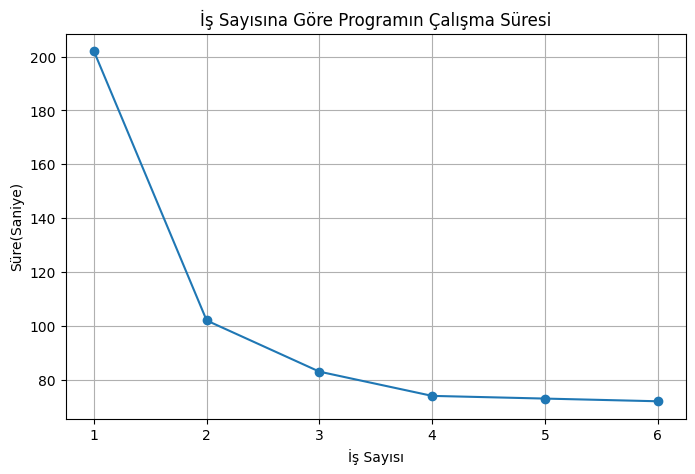

In [84]:
import matplotlib.pyplot as plt

n_p_jobs = [1, 2, 3, 4, 5, 6]
rations = [202, 102, 83, 74, 73, 72] 

plt.figure(figsize=(8, 5))
plt.plot(n_p_jobs, rations, marker='o')

plt.title("İş Sayısına Göre Programın Çalışma Süresi")
plt.xlabel("İş Sayısı")
plt.ylabel("Süre(Saniye)")

plt.xticks(n_p_jobs)  
plt.grid(True)
plt.show()


'verbose' değişkeninin çalışma zamanına ufak tefek etkileri oldu. Muhtemelen kalan çalışmalarımda 2 değerini vererek kullanırım. Programın ilerleyişini izlemek eğlenceli.

## Veriyi Dengeli Hale Getirmek
Çalışmanın başında da bahsettiğimiz gibi veri setimiz oldukça dengesizdi %0,172 oranında dolandırıcılık faaliyeti vardı, verinin kalanı dolandırıcılık faaliyeti içermiyordu. 1 ve 0 sınıflarına ait örneklerin sayısını eşitlediğimizde ROC'un 0.85'den 0.93'e yükseldiğini gözlemledik. 0 sınıfının sayısını 80 000 yaptığımızdaysa en başarılı skorları elde ettik. Bu sebepten kalan testleri 490/80 000 oranıyla devam ettireceğiz. Sonuçlar: <br>
* **Class1:** 490 **Class0:** 490    **ROC:** 0.93788 **F1:** 0.93670 **FP/(TP+FP):** 0.09756
* **Class1:** 490 **Class0:** 1000   **ROC:** 0.93125 **F1:** 0.92617 **FP/(TP+FP):** 0.1375
* **Class1:** 490 **Class0:** 2000   **ROC:** 0.91898 **F1:** 0.90476 **FP/(TP+FP):** 0.15555
* **Class1:** 490 **Class0:** 80000   **ROC:** 0.96954 **F1:** 0.93939 **FP/(TP+FP):** 0.06060
* **Class1:** 490 **Class0:** 284315 **ROC:** 0.85286 **F1:** 0.79558 **FP/(TP+FP):** 0.29411


*Veriyi on biner on biner arttırarak en yüksek skorları elde edebileceğimiz veri sayısını bulan kodu da yazabilirim bi ara.*

## Ağaç Sayısı
Ağaç sayısını düzenleyelim. Ağaç sayısıyla zaman doğru orantılı. Ağaç sayısını arttırdıkça doğrulukta dramatik bir artış olmasa da eğitim zamanı 3-4 katına çıkabiliyor. Sonuçlar:
* **Ağaç Sayısı:** 20 **ROC:** 0.96192 **F1:** 0.92424 **FP/(TP+FP):** 0.07575
* **Ağaç Sayısı:** 50 **ROC:** 0.96954 **F1:** 0.93939 **FP/(TP+FP):** 0.06060
* **Ağaç Sayısı:** 100 **ROC:** 0.96954 **F1:** 0.93939 **FP/(TP+FP):** 0.06060
* **Ağaç Sayısı:** 200 **ROC:** 0.96961 **F1:** 0.95384 **FP/(TP+FP):** 0.06060
* **Ağaç Sayısı:** 500 **ROC:** 0.96957 **F1:** 0.94656 **FP/(TP+FP):** 0.06060
100 ağaç fazlasıyla yeterli.

## Random State
Sınıflandırıcı fonksiyonumuzda random_state parametresini 
> random_state=RANDOM_STATE 

olarak kurmuştuk. Bu durumda elde ettiğimiz sonuçlar:
* **ROC:** 0.96954 **F1:** 0.93939 **FP/(TP+FP):** 0.06060 <br>
Bu parametreyi fonksiyondan silip default çalıştırdığımızda sonuçlar:
* **ROC:** 0.97715 **F1:** 0.95454 **FP/(TP+FP):** 0.04545 <br>
Diğer testlerde bu parametreyi default ayarında kullanacağız.

## Criterion
Gini Safsizligi, 0 ile 0.5 araliginda degerler alir. 0, homojen(tek sinif) veri setini, 0.5 ise tamamen heterojen(esit dagilimda kumeler) veri setini ifade eder. Criterion parametresini 'gini olarak değerlemiştik, şimdi diğer değerler için de sonuçları karşılaştıralım.
* **Criterion:** 'gini' **ROC:** 0.97715 **F1:** 0.95454 **FP/(TP+FP):** 0.04545
* **Criterion:** 'entropy' **ROC:** 0.0.96961 **F1:** 0.95384 **FP/(TP+FP):** 0.06060
* **Criterion:** 'log_loss' **ROC:** 0.0.96200 **F1:** 0.93846 **FP/(TP+FP):** 0.07575
<br>En başta kullandığımız değer olan 'gini' ile devam ediyoruz.


## Test/Eğitim Seti Oranı

* **Test-Eğitim:** 15-85 **ROC:** 0.91793 **F1:** 0.89473 **FP/(TP+FP):** 0.16393
* **Test-Eğitim:** 20-80 **ROC:** 0.97715 **F1:** 0.95454 **FP/(TP+FP):** 0.04545
* **Test-Eğitim:** 25-75 **ROC:** 0.915 **F1:** 0.90710 **FP/(TP+FP):** 0.17
* **Test-Eğitim:** 30-70 **ROC:** 0.92192 **F1:** 0.90196 **FP/(TP+FP):** 0.15596

20/80 iyidir:)